In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os 

Aliases

In [2]:
tfd = tfp.distributions

In [3]:
tfp.__version__

'0.17.0'

## Basic Environment

#### Bernoulli bandit

Set up the most simple bandit with two arms with a static probability for success for each arm.

\begin{align}
r_i \sim Bernoulli(p_i) \\
p_i \sim Beta(a_i, b_i)
\end{align}

In [4]:
arm_probs = [0.5, 0.8, 0.3]
bern_bandit = [tfd.Bernoulli(probs=x, name=f'arm_{i}') for i, x in enumerate(arm_probs)]

2022-07-23 12:31:12.575420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 12:31:12.604127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 12:31:12.604288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 12:31:12.605342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
bern_bandit

[<tfp.distributions.Bernoulli 'arm_0' batch_shape=[] event_shape=[] dtype=int32>,
 <tfp.distributions.Bernoulli 'arm_1' batch_shape=[] event_shape=[] dtype=int32>,
 <tfp.distributions.Bernoulli 'arm_2' batch_shape=[] event_shape=[] dtype=int32>]

## Bernoulli Bayesian Agent

As the Bandit is binary with Bernoulli (Binomial) likelihood we can use a Beta distribution as the prior to describe our understanding of the probability of success for each arm of the bandit. We will use totally uninformed prior of the probability for each arm.

In [6]:
uniform_prior = tfd.Beta(
    concentration1=1, # a
    concentration0=1, # b
    force_probs_to_zero_outside_support=True,
    name = 'beta'
)

<AxesSubplot:title={'center':'Probability Prior'}, xlabel='$p_i$'>

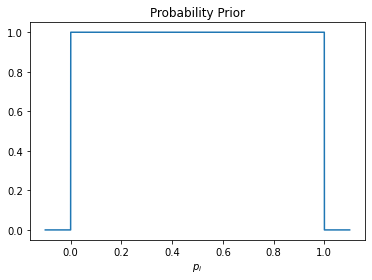

In [25]:
lin_x = np.arange(-0.1, 1.1, 0.0001)
y = uniform_prior.prob(lin_x)
fig, ax = plt.subplots(1,1)
ax.set_title("Probability Prior")
ax.set_xlabel(r"$p_i$")
sns.lineplot(x=lin_x, y=y, ax=ax)

In [26]:
num_arms = 3

In [27]:
arms = [[0,0] for _ in range(num_arms)]

In [28]:
arms

[[0, 0], [0, 0], [0, 0]]

In [29]:
def select_arm(arms):
    s = []
    for x in arms:
        a = x[0] + 1 # successes + 1
        b = x[1] - x[0] + 1 # failures + 1
        s.append(tfd.Beta(
            concentration1=a, 
            concentration0=a, 
        ).sample())
    return np.argmax(s)

In [30]:
# sample_arms(arms)

In [31]:
def pull_arm(arm, environment):
    return environment[arm].sample()

In [32]:
def agent_action():
    arm_number = select_arm(arms)
    reward = pull_arm(arm_number, bern_bandit)
    arms[arm_number][1] += 1
    if reward == 1:
        arms[arm_number][0] += 1
    

In [33]:
agent_action()

Using the above testing, we define a Bayesian agent class for the simple Bernoulli bandit as 

In [34]:
class BayesianAgent():
    def __init__(self, num_arms):
        self.num_arms = num_arms
        
        self.stats = {
            "total_actions" : 0,
            "total_reward" : 0
        }
        
        self.arms = [[0,0] for _ in range(num_arms)]
        
    def _sample_arms(self):
        s = []
        for x in self.arms:
            a = x[1] + 1 # successes + 1
            b = x[0] - x[1] + 1 # failures + 1
            s.append(tfd.Beta(
                concentration1=a, 
                concentration0=b, 
            ).sample())
        return np.argmax(s)
    
    def _pull_arm(self, arm_choice, environment):
        return environment[arm_choice].sample().numpy()
    
    def _update_arms(self, arm_choice, reward):
        self.arms[arm_choice][0] += 1 # add arm pull
        if reward == 1:
            self.arms[arm_choice][1] += 1 # add arm success
        self.stats['total_actions'] += 1  
        self.stats['total_reward'] += reward 
            
    def action(self, environment):
        arm_choice = self._sample_arms()
        reward = self._pull_arm(arm_choice, environment)
        self._update_arms(arm_choice, reward)
        
    def off_policy_update(self, data):
        pass
        
    def __repr__(self):
        return str(self.stats)

Instantiate the Bandit Agent with the number of arms the same as the bandit

In [35]:
agent = BayesianAgent(len(bern_bandit))

Test the initial output

In [36]:
agent

{'total_actions': 0, 'total_reward': 0}

Perform first sample and action

In [37]:
agent.action(bern_bandit)

Get the updated output

In [38]:
agent

{'total_actions': 1, 'total_reward': 0}

In [39]:
agent.action(bern_bandit)

In [40]:
agent

{'total_actions': 2, 'total_reward': 1}

Show the updating process

In [41]:
def plot_posterior(agent, iteration):
    lin_x = np.arange(0, 1, 0.001)
    ncols = agent.num_arms
    
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(5*ncols, 8))
    for i in range(ncols):
        a = agent.arms[i][1] + 1 # successes + 1
        b = agent.arms[i][0] - agent.arms[i][1] + 1 # failures + 1
        y = tfd.Beta(
            concentration1=a, 
            concentration0=b, 
        ).prob(lin_x)
        
        mean = np.round((a + b)/b, 1)
        successes = agent.arms[i][1]
        failures = agent.arms[i][0] - agent.arms[i][1]
        
        text = f"""
        mean_prob: {mean}
        s = {successes}
        f = {failures}
        """
        
        sns.lineplot(x=lin_x, y=y, ax=ax[i])
        ax[i].set_xlabel("payout_prob")
        ax[i].set_title(f"Arm {i} \n pulls: {agent.arms[i][0]}, successes: {agent.arms[i][1]}")
        # ax[i].text(0.95, 0.05, text, horizontalalignment='left', verticalalignment='top',)
        # transform=ax[i].transAxes
        # Add in true value of probability
        ax[i].vlines(x=arm_probs[i], ymin=0, ymax=5, colors='r', linestyles='--')
    fig.suptitle(f"Iteration: {iteration}")
    fig.tight_layout()
            

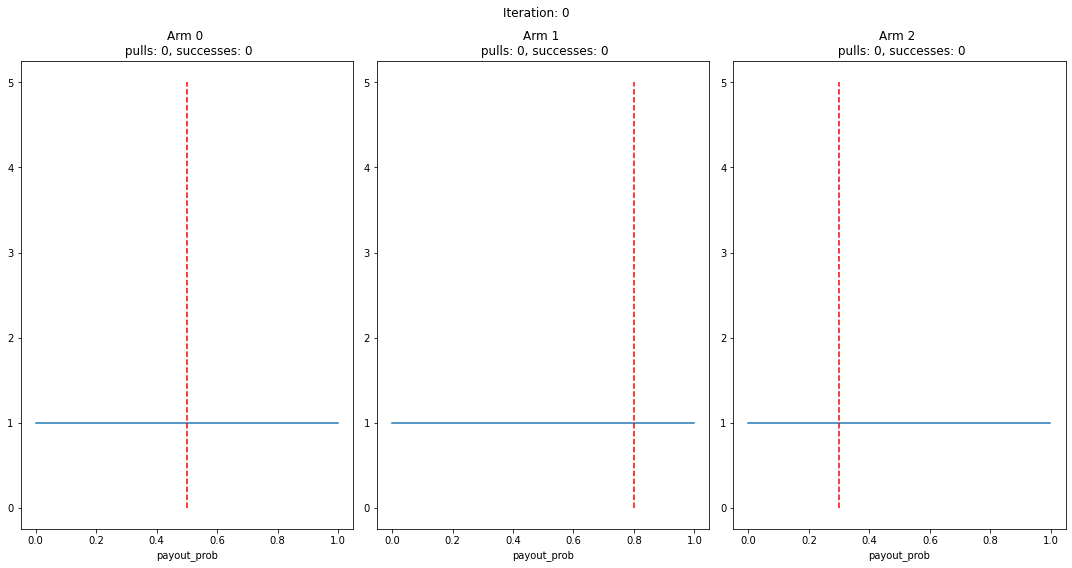

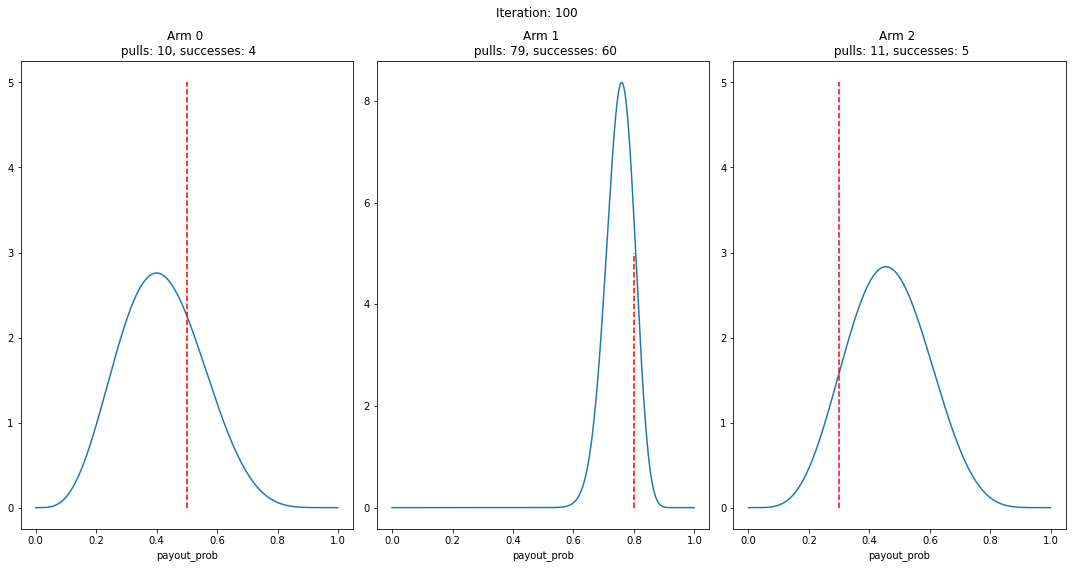

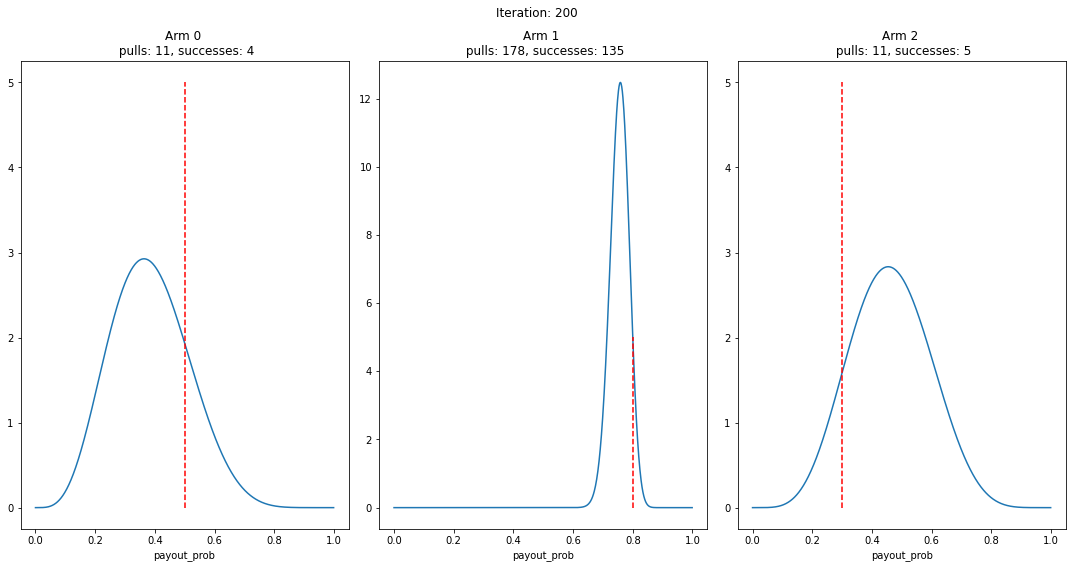

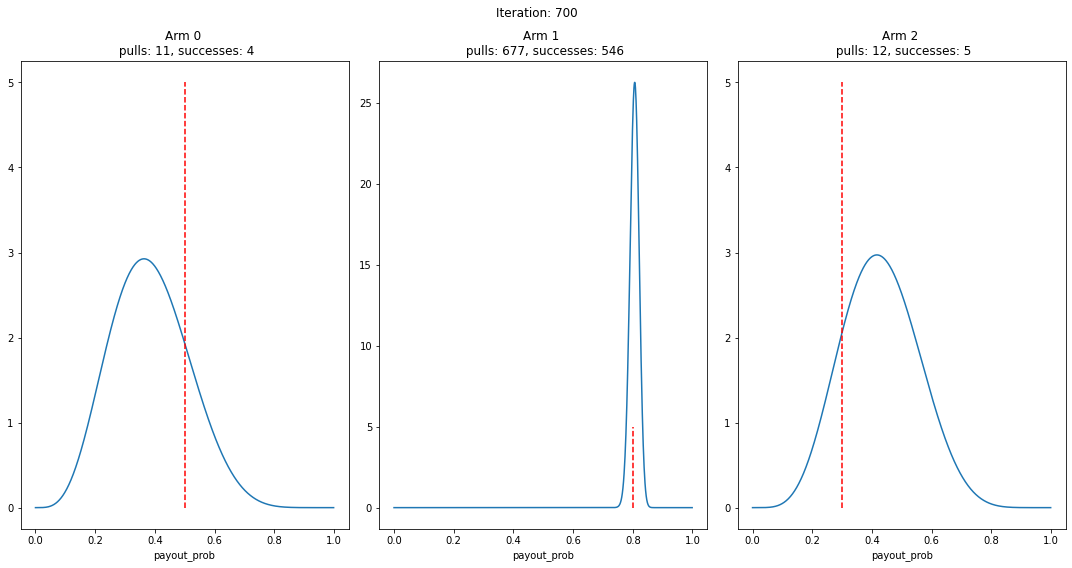

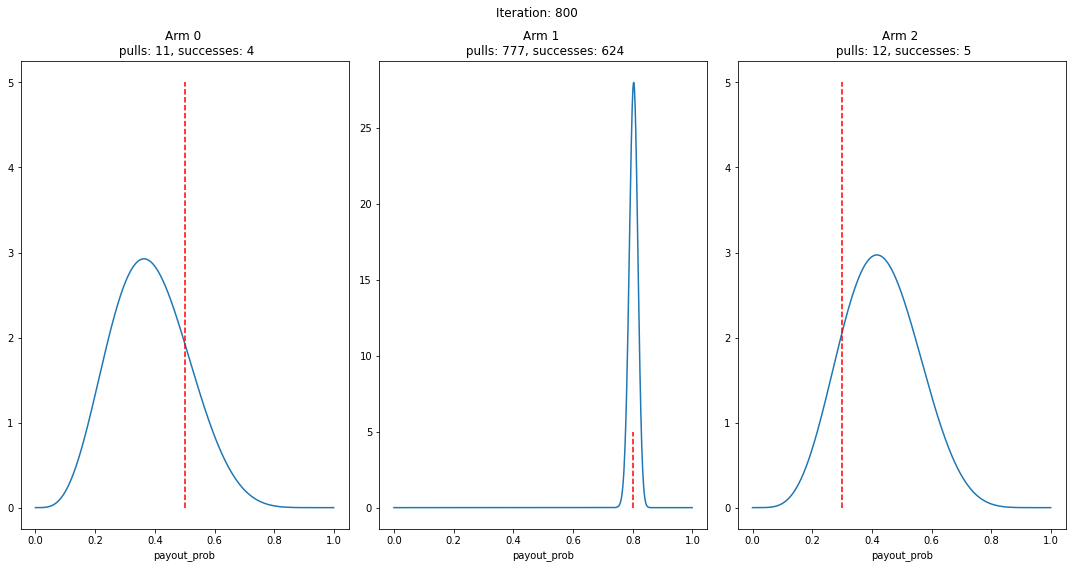

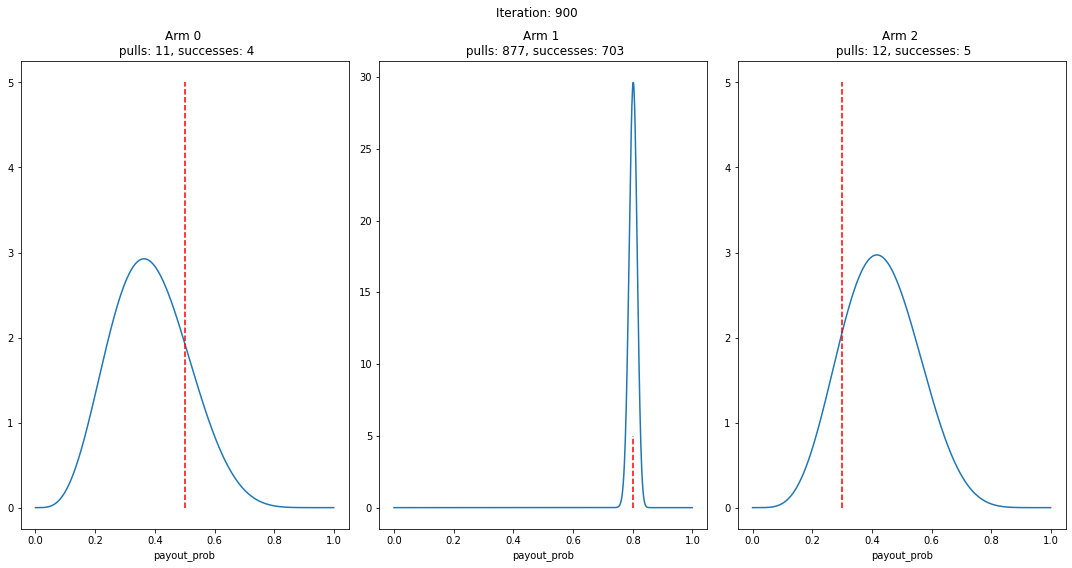

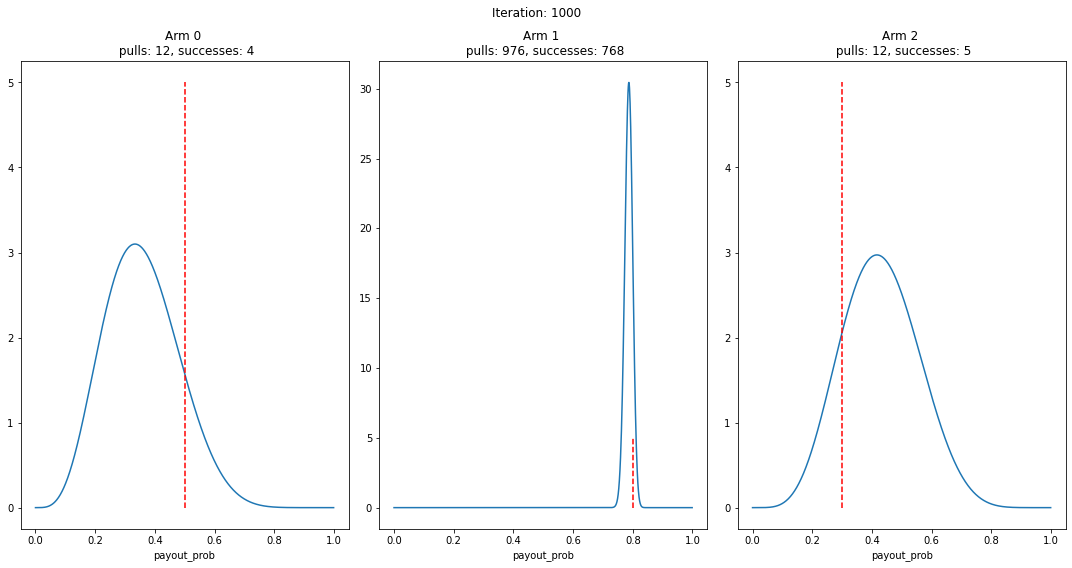

In [42]:
num_iteration = 1001
agent = BayesianAgent(len(bern_bandit))
for i in range(num_iteration):
    if i%100 == 0:
        plot_posterior(agent, i)
    agent.action(bern_bandit)

As you can see, the Thompson sampling approach does not aim to accurately learn the probability of all arms equally. As soon as the probability distribution of the dominant arm is certain enough such that samples from it will always beat the other arms then it will only exploit. This can also cause some issues, if the agent if the posterior has an erroneously high probability density through updating, it will tend exploit it more when it should be exploring.